# Purpose

This notebook contains code to generate local importance (input feature attribution) using different interpretation methods, such as LIME, SHAP, Layer-integrated-gradients, and CD-T, and compare.

In [ ]:
!pip install lime
!pip install shap
!pip install captum

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
import sys
import gc
import torch
import random
warnings.filterwarnings("ignore")
base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from pyfunctions.local_importance import *

In [4]:
torch.autograd.set_grad_enabled(False)

In [213]:
device = 'cuda:0'
supported_model_and_task = {"bert": ["pathology", "sst2", "agnews"], "gpt2": ["ioi"]}
model_type = 'gpt2' #"bert", "gpt2"
data_name = supported_model_and_task[model_type][0] #"bert""pathology", "sst2", "agnews", "ioi"

if data_name == "sst2":
    max_seq_len = 120
    class_names = ["0", "1"]
if data_name == "agnews":
    max_seq_len = 240
    class_names = ["0", "1", "2", "3"]
elif data_name == "pathology":
    max_seq_len = 512
    class_names = ["3", "4", "5"]
elif data_name == "ioi":
    max_seq_len = 16
    class_names = [str(token_id) for token_id in range(50257)]

In [214]:
# load in data and model
data, le_dict, tokenizer, model = load_data_and_model(data_name, model_type, device) # the wrapper currently only support a fixed set of models and datasets

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda:0


## Compute dataset stats

In [ ]:
# Prepare AGNews-long -> 34 datapoints
idx = []
for i, text in enumerate(data['docs']):
    text_ids = tokenizer.encode(text)
    if len(text_ids) > 150:
        idx.append(i)
    if len(idx) == 50:
        break

In [259]:
idx = random.sample(range(len(data['docs'])), 34)
agnews_text_data_random, agnews_label_data_random = [], []
for i in idx:
    agnews_text_data_random.append(data['docs'][i])
    agnews_label_data_random.append(data['labels'][i])

In [ ]:
idx = random.sample(range(len(data['docs'])), 34)
sst2_text_data, sst2_label_data = [], []
for i in idx:
    sst2_text_data.append(data['docs'][i])
    sst2_label_data.append(data['labels'][i])

In [ ]:
idx = random.sample(range(len(data['docs'])), 34)
path_text_data, path_label_data = [], []
for i in idx:
    path_text_data.append(data['docs'][i])
    path_label_data.append(data['labels'][i])

In [ ]:
idx = random.sample(range(len(data.sentences)), 34)
ioi_sample_id = idx

In [260]:
sample_data_dict = {"ioi": ioi_sample_id, "sst2": sst2_text_data, "agnews": agnews_text_data, "agnews_rand": agnews_text_data_random, "pathology": path_text_data}

In [261]:
sample_labels_dict = {"ioi": None, "sst2": sst2_label_data, "agnews": agnews_label_data, "agnews_rand": agnews_label_data_random, "pathology": path_label_data}

In [ ]:
tot = []
for x in ["ioi", "sst2", "agnews", "pathology"]:
    sample_data = sample_data_dict[x]
    res = []
    for text in tqdm.tqdm(sample_data):
        if x == "ioi":
            # "text" is actually sample_id for ioi task
            text = data.sentences[text]
            text_ids = tokenizer.encode(text)
        else:
            text_ids = tokenizer.encode(text)
        res.append(len(text_ids))
    tot.append(res)

Text(0, 0.5, 'Token Counts')

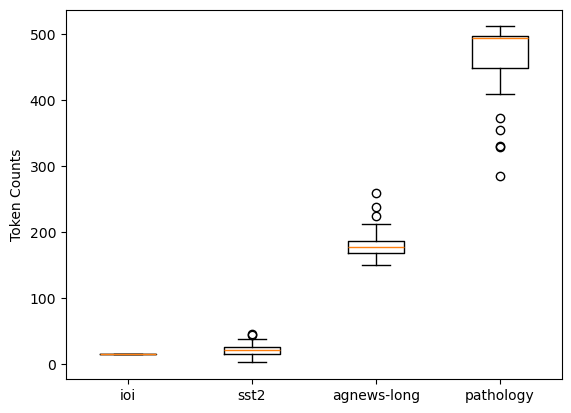

In [227]:
plot = matplotlib.pyplot.boxplot(tot, labels = ["ioi", "sst2", "agnews-long", "pathology"] )
matplotlib.pyplot.ylabel("Token Counts")

In [ ]:
np.median(tot, axis=1)

In [262]:
import json
# save sample data for reproducibility
with open('new_local_importance_sample_text.json', 'w') as f:
    json.dump(sample_data_dict, f)

with open('new_local_importance_sample_label.json', 'w') as f:
    json.dump(sample_labels_dict, f)

## Run local interpretation

In [265]:
# for reproducibility reasons

with open('new_local_importance_sample_text.json', 'r') as f:
    sample_data_dict = json.load(f)
    
with open('new_local_importance_sample_label.json', 'r') as f:
    sample_labels_dict = json.load(f)

In [ ]:
methods = ["lime", "shap", "CDT", "LIG"]

print(f'Running dataset {data_name}...')
sample_data = sample_data_dict[data_name][:10]
sample_labels = sample_labels_dict[data_name][:10]

# check for these data: pred == gt_label
for gt_label, text in zip(sample_labels, sample_data):
    outputs = model(**tokenizer(text, 
                                 max_length=max_seq_len,
                                 truncation=True, 
                                 padding = "max_length", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device))
    tensor_logits = outputs[0]
    pred = torch.argmax(tensor_logits).detach().cpu().numpy()
    try:
        assert(gt_label, pred)
    except:
        print(gt_label, pred)
        
for method in methods:
    print(f'Running method {method}...')
    for i in range(len(sample_data)):
        print("="*10 + f' sample {i} ' + "="*10)
        if data_name != "ioi":
            tokenized_prompt = None
            io_seq_idx = None
            s_seq_idx = None
            text = sample_data[i].strip().lower()
            label = sample_labels[i]
            label_idx = le_dict[label]
            tokenizer.pad_token = tokenizer.eos_token
        else:
            sample_id = sample_data[i]
            tokenized_prompt = data.tokenized_prompts[sample_id]
            io_seq_idx = data.io_tokenIDs[sample_id] # sample_id 0-50 for ioi
            s_seq_idx = data.s_tokenIDs[sample_id] 
            text = data.sentences[sample_id]
            label_idx = None

        # clear cache
        gc.collect()
        torch.cuda.empty_cache()
        
        scores = run_local_importance(text, tokenized_prompt, io_seq_idx, s_seq_idx, label_idx, max_seq_len, model, tokenizer,
                              device, method, model_type, class_names)
        print("="*20)